In [139]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score
import warnings, random, os
import math
warnings.filterwarnings("ignore")
from tensorflow.keras import layers, models, optimizers, losses, metrics
SEED = 41
np.random.seed(SEED)
random.seed(SEED)


In [140]:
# 1️⃣ Load CMAPSS FD001 dataset
# ----------------------------- #
try:
    df = pd.read_csv("train_FD001.txt", sep='\s+', header=None)
    col_names = ['unit','cycle'] + [f'op{i+1}' for i in range(3)] + [f's{i+1}' for i in range(21)]
    df = df.iloc[:, :len(col_names)]
    df.columns = col_names
    print("✅ Loaded real CMAPSS FD001 file")
except Exception:
    print("⚠️ No CMAPSS FD001 file found — generating synthetic demo data.")
    n_units = 100
    max_cycles = 200
    rows=[]
    for u in range(1,n_units+1):
        cycles = np.random.randint(120, max_cycles)
        for c in range(1, cycles+1):
            op = np.random.normal(0,1,3)
            s = np.random.normal(0,1,21)
            for di in [2,5,8]:
                s[di] += (c/cycles)*np.random.uniform(1.0,3.0)
            rows.append([u,c,*op,*s])
    df = pd.DataFrame(rows, columns=['unit','cycle']+[f'op{i+1}' for i in range(3)]+[f's{i+1}' for i in range(21)])

print("Data shape:", df.shape)

# ----------------------------- #

✅ Loaded real CMAPSS FD001 file
Data shape: (20631, 26)


In [141]:
# 1️⃣ Load CMAPSS FD001 dataset
# ----------------------------- #
try:
    df_test = pd.read_csv("test_FD001.txt", sep='\s+', header=None)
    col_names = ['unit','cycle'] + [f'op{i+1}' for i in range(3)] + [f's{i+1}' for i in range(21)]
    df_test = df_test.iloc[:, :len(col_names)]
    df_test.columns = col_names
    print("✅ Loaded real CMAPSS FD001 file")
except Exception:
    print("⚠️ No CMAPSS FD001 file found — generating synthetic demo data.")
    n_units = 100
    max_cycles = 200
    rows=[]
    for u in range(1,n_units+1):
        cycles = np.random.randint(120, max_cycles)
        for c in range(1, cycles+1):
            op = np.random.normal(0,1,3)
            s = np.random.normal(0,1,21)
            for di in [2,5,8]:
                s[di] += (c/cycles)*np.random.uniform(1.0,3.0)
            rows.append([u,c,*op,*s])
    df_test = pd.DataFrame(rows, columns=['unit','cycle']+[f'op{i+1}' for i in range(3)]+[f's{i+1}' for i in range(21)])

print("Data shape:", df_test.shape)

# ----------------------------- #

✅ Loaded real CMAPSS FD001 file
Data shape: (13096, 26)


In [142]:
# 2️⃣ Preprocessing for Training
# ----------------------------- #
drop_sensors = ['op1','op2','op3','s1','s5','s6','s10','s16','s18','s19']
features = [c for c in df.columns if c not in ['unit','cycle'] + drop_sensors]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[features])
df_scaled = pd.DataFrame(X_scaled, columns=features)
df_scaled['unit']  = df['unit']
df_scaled['cycle'] = df['cycle']

# ----------------------------- #

In [143]:
# 2️⃣ Preprocessing for Testing
# ----------------------------- #
drop_sensors = ['op1','op2','op3','s1','s5','s6','s10','s16','s18','s19']
features_test = [c for c in df_test.columns if c not in ['unit','cycle'] + drop_sensors]

X_test_scaled = scaler.transform(df_test[features_test])
df_test_scaled = pd.DataFrame(X_test_scaled, columns=features_test)
df_test_scaled['unit']  = df['unit']
df_test_scaled['cycle'] = df['cycle']

# ----------------------------- #

In [144]:
# 3️⃣ Autoencoder or PCA (latent)
# ----------------------------- #
latent_dim = 32
try:
    import tensorflow as tf
    from tensorflow.keras import layers, models, optimizers, callbacks
    tf.random.set_seed(SEED)
    inp = layers.Input(shape=(len(features),))
    x = layers.Dense(128, activation='relu')(inp)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    z = layers.Dense(latent_dim, name='latent')(x)
    x2 = layers.Dense(128, activation='relu')(z)
    x2 = layers.Dropout(0.2)(x2)
    x2 = layers.Dense(128, activation='relu')(x2)
    x2 = layers.Dropout(0.2)(x2)
    out = layers.Dense(len(features))(x2)
    auto = models.Model(inp, out)
    encoder = models.Model(inp, z)
    auto.compile(optimizer=optimizers.Adam(1e-3), loss='mse')
    es = callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
    auto.fit(X_scaled, X_scaled, epochs=400, batch_size=8, validation_split=0.1,
             verbose=1, callbacks=[es])
    Z_all = encoder.predict(X_scaled, batch_size=256)
    method_used = "Autoencoder"
except Exception:
    # fallback PCA if TF unavailable
    pca = PCA(n_components=min(latent_dim, len(features)), random_state=42)
    Z_all = pca.fit_transform(X_scaled)
    method_used = "PCA"
print(f"Latent extractor used: {method_used}")

df_latent = pd.DataFrame(Z_all, columns=[f'z{i+1}' for i in range(Z_all.shape[1])])
df_latent['unit'] = df['unit']
df_latent['cycle'] = df['cycle']

# ----------------------------- #

Epoch 1/400
2321/2321 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.1989 - val_loss: 0.0665
Epoch 2/400
2321/2321 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.1389 - val_loss: 0.0475
Epoch 3/400
2321/2321 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.1271 - val_loss: 0.0536
Epoch 4/400
2321/2321 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.1219 - val_loss: 0.0471
Epoch 5/400
2321/2321 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.1187 - val_loss: 0.0437
Epoch 6/400
2321/2321 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.1190 - val_loss: 0.0414
Epoch 7/400
2321/2321 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.1161 - val_loss: 0.0498
Epoch 8/400
2321/2321 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.1173 - val_loss: 0.0435
Epoch 9/400
2321/2321 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.1148 - val_loss: 0.0525
Epoch 10/400
2321/2321 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.1136 - val_loss: 0.0382
Epoch 11/400
2321/2321 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.1130 - val_loss: 0.0370
Epoch 12/400
2321/2

In [145]:
# 4️⃣ Aggregate per engine
# ----------------------------- #
agg = df_latent.groupby('unit').mean().reset_index()
latent_cols = [c for c in agg.columns if c.startswith('z')]
X_agg_std = StandardScaler().fit_transform(agg[latent_cols])

# ----------------------------- #

In [146]:
# 5️⃣ GMM clustering (K=3)
# ----------------------------- #
gmm = GaussianMixture(n_components=3, covariance_type='full', n_init=10, random_state=42)
gmm.fit(X_agg_std)

# Hard cluster assignment
agg['cluster'] = gmm.predict(X_agg_std)    # cluster labels 0,1,2 (arbitrary ordering)

# Optional: posterior probabilities (useful for Fig.3)
posteriors = gmm.predict_proba(X_agg_std)  # shape (n_units, 3)
# store them in agg if you want:
for k in range(posteriors.shape[1]):
    agg[f'prob_c{k}'] = posteriors[:, k]

# --- 1) Compute cluster "MAD from zero" scores (our custom health score) ---
cluster_ids = np.unique(agg['cluster'].values)
cluster_scores = {}
for cid in cluster_ids:
    idx = (agg['cluster'].values == cid)
    if idx.sum() == 0:
        cluster_scores[cid] = np.inf
        continue
    # rows in standardized aggregated latent space for this cluster
    cluster_rows = X_agg_std[idx, :]    # shape (n_units_in_cluster, n_latent_dims)
    # mean absolute deviation from zero across units and latent dims
    mad = np.mean(np.abs(cluster_rows))
    cluster_scores[cid] = mad

# Print raw scores
print("Cluster MAD scores (lower => closer to standardized zero):")
for cid, sc in cluster_scores.items():
    print(f"  Cluster {cid}: MAD = {sc:.4f}")

# --- 2) Map clusters -> health labels using MAD ordering (post-hoc heuristic) ---
# Sort cluster ids by MAD ascending (smallest MAD = most "normal" = Healthy)
sorted_by_mad = sorted(cluster_scores.keys(), key=lambda c: cluster_scores[c])
mad_label_order = ['Healthy', 'Middle', 'Unhealthy']

# If more/fewer clusters than 3, adapt the labels list length safely
mapping_by_mad = {}
for i, cid in enumerate(sorted_by_mad):
    mapping_by_mad[cid] = mad_label_order[i] if i < len(mad_label_order) else f"State_{i}"

# Apply mapping
agg['health_state_mad'] = agg['cluster'].map(mapping_by_mad)

print("\nMapping derived from MAD heuristic (cluster -> health_state_mad):")
for cid in sorted_by_mad:
    print(f"  Cluster {cid} -> {mapping_by_mad[cid]}  (n={(agg['cluster']==cid).sum()})")

# --- 3) Diagnostics: silhouette, sizes, mean latent per labeled state ---
try:
    sil = silhouette_score(X_agg_std, agg['cluster'])
except Exception as e:
    sil = None
    print("Silhouette score could not be computed:", e)

print("\nCluster sizes (counts):")
print(agg['cluster'].value_counts().sort_index())

# mean aggregated latent (first 5 dims) per MAD-labeled health state (sanity check)
state_means = agg.groupby('health_state_mad')[latent_cols].mean()
print("\nMean aggregated latent (first 5 dims) per health_state_mad:")
print(state_means.iloc[:, :min(5, state_means.shape[1])].round(4))

print("\nSilhouette score:", round(sil, 3) if sil is not None else "N/A")

# --- 4) Optionally force a fixed mapping (override the MAD mapping)
# Use this if you want deterministic labels: cluster 0->Healthy, 1->Middle, 2->Unhealthy
force_fixed_mapping = False   # <-- set to True to enforce the fixed mapping
fixed_map = {0: 'Healthy', 1: 'Middle', 2: 'Unhealthy'}

if force_fixed_mapping:
    # Validate that cluster IDs match expected set (0,1,2)
    present = set(agg['cluster'].unique())
    expected = set(fixed_map.keys())
    if not present.issubset(set(range(max(present)+1))):
        # still allow override even if clusters are other numbers, map where possible
        pass
    agg['health_state'] = agg['cluster'].map(fixed_map).fillna(agg['health_state_mad'])
    print("\nFixed mapping applied: cluster->health_state (cluster->fixed_map; fallback to MAD mapping)")
else:
    # Keep MAD-based mapping (recommended unless you need deterministic cluster numbers)
    agg['health_state'] = agg['health_state_mad']

# Show final mapping used
print("\nFinal health_state value counts:")
print(agg['health_state'].value_counts())
print("Silhouette score:", round(sil, 3) if sil is not None else "N/A")
# Add a small assertion to catch unexpected labels
assert set(agg['health_state'].unique()).issubset({'Healthy','Middle','Unhealthy'}), \
       f"Unexpected health_state labels found: {set(agg['health_state'].unique())}"
# -----------------------------

Cluster MAD scores (lower => closer to standardized zero):
  Cluster 0: MAD = 0.7115
  Cluster 1: MAD = 0.8578
  Cluster 2: MAD = 1.1129

Mapping derived from MAD heuristic (cluster -> health_state_mad):
  Cluster 0 -> Healthy  (n=63)
  Cluster 1 -> Middle  (n=19)
  Cluster 2 -> Unhealthy  (n=18)

Cluster sizes (counts):
cluster
0    63
1    19
2    18
Name: count, dtype: int64

Mean aggregated latent (first 5 dims) per health_state_mad:
                      z1      z2      z3      z4      z5
health_state_mad                                        
Healthy           0.0232 -0.1099 -0.0732 -0.0395  0.0926
Middle           -0.3815 -0.0938 -0.0057 -0.0839  0.1936
Unhealthy        -0.1812 -0.0644  0.0527 -0.1437 -0.0383

Silhouette score: 0.369

Final health_state value counts:
health_state
Healthy      63
Middle       19
Unhealthy    18
Name: count, dtype: int64
Silhouette score: 0.369


In [147]:
# If you want to see how many engines per health state:
agg.groupby('health_state')['unit'].count()

health_state
Healthy      63
Middle       19
Unhealthy    18
Name: unit, dtype: int64

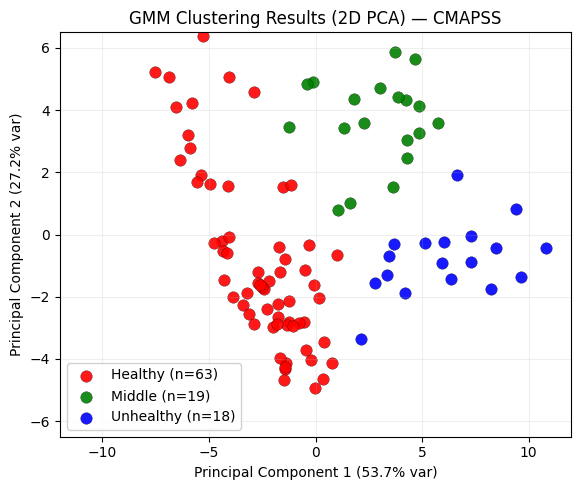

CMAPSS: PC1=53.7%, PC2=27.2%, counts: {'Healthy': 63, 'Middle': 19, 'Unhealthy': 18}


In [148]:
# ---------- 2D PCA plot of clustered engines (CMAPSS vs real-life if available) ----------# Prepare inputs: left = current agg (CMAPSS). Right = agg_real if provided.
pca_inputs = [('CMAPSS', agg, X_agg_std)]
if 'agg_real' in globals() and 'X_agg_std_real' in globals():
    # ensure real dataset uses same label mapping
    agg_real['health_state'] = agg_real['cluster'].map(fixed_map)
    pca_inputs.append(('Real-life', agg_real, X_agg_std_real))

n_plots = max(1, len(pca_inputs))
fig, axes = plt.subplots(1, n_plots, figsize=(6 * n_plots, 5), squeeze=False)
axes = axes.flatten()

# Color map for states
state_colors = {'Healthy':'red', 'Middle':'green', 'Unhealthy':'blue'}
state_order = ['Healthy', 'Middle', 'Unhealthy']  # consistent plotting order

for ax, (title, df_in, X_in) in zip(axes, pca_inputs):
    # run PCA (2D)
    pca = PCA(n_components=2, random_state=42)
    proj = pca.fit_transform(X_in)
    var1 = pca.explained_variance_ratio_[0] * 100
    var2 = pca.explained_variance_ratio_[1] * 100

    # plot each health state, ensuring consistent colors and legend entries with counts
    for state in state_order:
        mask = df_in['health_state'] == state
        if mask.sum() == 0:
            continue
        ax.scatter(proj[mask,0], proj[mask,1],
                   label=f"{state} (n={mask.sum()})",
                   c=state_colors[state],
                   edgecolor='k', linewidth=0.2, s=70, alpha=0.9)

    # axis labels & title
    ax.set_xlabel(f"Principal Component 1 ({var1:.1f}% var)")
    ax.set_ylabel(f"Principal Component 2 ({var2:.1f}% var)")
    ax.set_title(f"GMM Clustering Results (2D PCA) — {title}")

    # set axis limits with some padding for visual clarity
    x_min, x_max = proj[:,0].min(), proj[:,0].max()
    y_min, y_max = proj[:,1].min(), proj[:,1].max()
    x_pad = max(10.0, (x_max - x_min) * 0.08)
    y_pad = max(10.0, (y_max - y_min) * 0.08)
    ax.set_xlim(x_min - x_pad, x_max + x_pad)
    ax.set_ylim(y_min - y_pad, y_max + y_pad)

    ax.grid(alpha=0.2)
    ax.legend(loc='best', framealpha=0.9)

# If there is an empty right panel (no real dataset), annotate it
if len(pca_inputs) == 1 and n_plots == 1:
    # nothing to do — single plot shown
    pass
elif len(pca_inputs) == 1 and n_plots == 2:
    # annotate empty second subplot (shouldn't usually happen)
    axes[1].text(0.5, 0.5, "No real-life dataset (agg_real) found", ha='center', va='center', transform=axes[1].transAxes)

plt.tight_layout()
plt.ylim(-6.5,6.5)
plt.xlim(-12,12)
plt.savefig("pca_gmm_clusters.png", dpi=900)
plt.show()

# Print a short summary
for title, df_in, X_in in pca_inputs:
    try:
        pca = PCA(n_components=2, random_state=42)
        pca.fit(X_in)
        print(f"{title}: PC1={pca.explained_variance_ratio_[0]*100:.1f}%, PC2={pca.explained_variance_ratio_[1]*100:.1f}%, counts: ", end='')
        print(df_in['health_state'].value_counts().reindex(state_order).fillna(0).astype(int).to_dict())
    except Exception as e:
        print(f"{title}: PCA failed: {e}")

In [149]:
z_test = encoder.predict(X_test_scaled, batch_size=256) 
df_test_latent = pd.DataFrame(z_test, columns=[f'z{i+1}' for i in range(z_test.shape[1])])
df_test_latent['unit'] = df_test['unit']
df_test_latent['cycle'] = df_test['cycle']


52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


In [150]:
# 4️⃣ Aggregate per engine
# ----------------------------- #
agg_test = df_test_latent.groupby('unit').mean().reset_index()
latent_cols = [c for c in agg_test.columns if c.startswith('z')]
X_agg_test_std = StandardScaler().fit_transform(agg_test[latent_cols])

# ----------------------------- #

In [151]:
from tensorflow.keras import layers, models, optimizers
import tensorflow as tf

def build_lstm_rul_model(seq_len, nfeat,
                         lstm_units=128,
                         dense_units=64,
                         dropout=0.2,
                         lr=1e-3):

    inp = layers.Input(shape=(seq_len, nfeat), name="seq_input")

    x = layers.LSTM(lstm_units, return_sequences=True)(inp)

    # extract last timestep only
    last = layers.Lambda(lambda z: z[:, -1, :])(x)

    x = layers.Dense(dense_units, activation="relu")(last)
    x = layers.Dropout(dropout)(x)

    out = layers.Dense(1, activation="linear")(x)

    model = models.Model(inputs=inp, outputs=out)
    model.compile(
        optimizer=optimizers.Adam(learning_rate=lr),
        loss="mse",
        metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')]
    )
    return model


In [152]:
def create_windows(df, feature_cols, seq_len=30, stride=1, target_col='rul'):
    Xs, ys, meta = [], [], []
    for unit, g in df.groupby('unit'):
        g = g.sort_values('cycle').reset_index(drop=True)
        feats = g[feature_cols].values
        targ = g[target_col].values

        for end in range(seq_len-1, len(g), stride):
            start = end - (seq_len - 1)
            Xs.append(feats[start:end+1])
            ys.append(targ[end])       # last timestep target
            meta.append((unit, g.loc[end, 'cycle']))

    return np.array(Xs), np.array(ys), meta


In [153]:
def nasa_score(y_true, y_pred):
    diff = y_pred - y_true
    score = np.where(diff < 0, np.exp(-diff / 13) - 1,
                              np.exp(diff / 10) - 1)
    return np.sum(score)


In [154]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

def train_statewise_lstm(df_latent, agg_df, latent_cols,
                         seq_len=30, stride=1,
                         test_size=0.2, val_split=0.1,
                         epochs=100, batch_size=32, patience=10,
                         out_dir="./models_state",
                         model_builder=build_lstm_rul_model):

    import os
    os.makedirs(out_dir, exist_ok=True)

    df_latent = compute_rul_per_row(df_latent)
    df_latent['health_state'] = df_latent['unit'].map(dict(zip(agg_df['unit'], agg_df['health_state'])))

    results = {}

    for state in df_latent['health_state'].unique():

        df_state = df_latent[df_latent['health_state'] == state].copy()

        units = df_state['unit'].unique()
        train_units, test_units = train_test_split(units, test_size=test_size, random_state=42)

        train_df = df_state[df_state['unit'].isin(train_units)]
        test_df = df_state[df_state['unit'].isin(test_units)]

        X_train, y_train, _ = create_windows(train_df, latent_cols, seq_len=seq_len)
        X_test, y_test, meta_test = create_windows(test_df, latent_cols, seq_len=seq_len)

        # Fit StandardScaler on training data only
        ntr, sl, nf = X_train.shape
        flat_tr = X_train.reshape(-1, nf)

        scaler = StandardScaler().fit(flat_tr)
        np.savez(os.path.join(out_dir, f"scaler_state_{state}.npz"),
                 mean=scaler.mean_, scale=scaler.scale_)

        # Scale training / test
        X_train = ((X_train - scaler.mean_) / scaler.scale_)
        X_test  = ((X_test  - scaler.mean_) / scaler.scale_)

        model = model_builder(seq_len, nf)

        es = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                              patience=patience,
                                              restore_best_weights=True)

        hist = model.fit(
            X_train, y_train,
            validation_split=val_split,
            epochs=epochs,
            batch_size=batch_size,
            callbacks=[es],
            verbose=1
        )

        model.save(os.path.join(out_dir, f"lstm_state_{state}.keras"))

        preds = model.predict(X_test).flatten()

        rmse = mean_squared_error(y_test, preds, squared=False)
        r2 = r2_score(y_test, preds)

        print(f"[State={state}] RMSE={rmse:.3f}, R2={r2:.3f}")

        results[state] = {
            "rmse": rmse,
            "r2": r2,
            "y_test": y_test,
            "y_pred": preds,
            "meta_test": meta_test,
            "history": hist.history
        }

    return results


In [155]:
SEQ_LEN = 30

results = train_statewise_lstm(
    df_latent=df_latent,
    agg=agg,
    latent_cols=latent_cols,
    seq_len=SEQ_LEN,
    stride=1,
    test_size=0.2,
    val_split=0.1,
    epochs=400,
    batch_size=8,
    patience=20,
    out_dir='./models_state',
    verbose=1
)


TypeError: train_statewise_lstm() got an unexpected keyword argument 'agg'

In [ ]:
# 5️⃣ GMM clustering (K=3)
# ----------------------------- #
gmm = GaussianMixture(n_components=3, covariance_type='full', n_init=10, random_state=42)
gmm.fit(X_agg_test_std)

# Hard cluster assignment
agg_test['cluster'] = gmm.predict(X_agg_test_std)    # cluster labels 0,1,2 (arbitrary ordering)

# Optional: posterior probabilities (useful for Fig.3)
posteriors = gmm.predict_proba(X_agg_test_std)  # shape (n_units, 3)
# store them in agg if you want:
for k in range(posteriors.shape[1]):
    agg[f'prob_c{k}'] = posteriors[:, k]

# --- 1) Compute cluster "MAD from zero" scores (our custom health score) ---
cluster_ids = np.unique(agg_test['cluster'].values)
cluster_scores = {}
for cid in cluster_ids:
    idx = (agg_test['cluster'].values == cid)
    if idx.sum() == 0:
        cluster_scores[cid] = np.inf
        continue
    # rows in standardized aggregated latent space for this cluster
    cluster_rows = X_agg_test_std[idx, :]    # shape (n_units_in_cluster, n_latent_dims)
    # mean absolute deviation from zero across units and latent dims
    mad = np.mean(np.abs(cluster_rows))
    cluster_scores[cid] = mad

# Print raw scores
print("Cluster MAD scores (lower => closer to standardized zero):")
for cid, sc in cluster_scores.items():
    print(f"  Cluster {cid}: MAD = {sc:.4f}")

# --- 2) Map clusters -> health labels using MAD ordering (post-hoc heuristic) ---
# Sort cluster ids by MAD ascending (smallest MAD = most "normal" = Healthy)
sorted_by_mad = sorted(cluster_scores.keys(), key=lambda c: cluster_scores[c])
mad_label_order = ['Healthy', 'Middle', 'Unhealthy']

# If more/fewer clusters than 3, adapt the labels list length safely
mapping_by_mad = {}
for i, cid in enumerate(sorted_by_mad):
    mapping_by_mad[cid] = mad_label_order[i] if i < len(mad_label_order) else f"State_{i}"

# Apply mapping
agg_test['health_state_mad'] = agg_test['cluster'].map(mapping_by_mad)

print("\nMapping derived from MAD heuristic (cluster -> health_state_mad):")
for cid in sorted_by_mad:
    print(f"  Cluster {cid} -> {mapping_by_mad[cid]}  (n={(agg_test['cluster']==cid).sum()})")

# --- 3) Diagnostics: silhouette, sizes, mean latent per labeled state ---
try:
    sil = silhouette_score(X_agg_test_std, agg_test['cluster'])
except Exception as e:
    sil = None
    print("Silhouette score could not be computed:", e)

print("\nCluster sizes (counts):")
print(agg_test['cluster'].value_counts().sort_index())

# mean aggregated latent (first 5 dims) per MAD-labeled health state (sanity check)
state_means = agg_test.groupby('health_state_mad')[latent_cols].mean()
print("\nMean aggregated latent (first 5 dims) per health_state_mad:")
print(state_means.iloc[:, :min(5, state_means.shape[1])].round(4))

print("\nSilhouette score:", round(sil, 3) if sil is not None else "N/A")

# --- 4) Optionally force a fixed mapping (override the MAD mapping)
# Use this if you want deterministic labels: cluster 0->Healthy, 1->Middle, 2->Unhealthy
force_fixed_mapping = False   # <-- set to True to enforce the fixed mapping
fixed_map = {0: 'Healthy', 1: 'Middle', 2: 'Unhealthy'}

if force_fixed_mapping:
    # Validate that cluster IDs match expected set (0,1,2)
    present = set(agg_test['cluster'].unique())
    expected = set(fixed_map.keys())
    if not present.issubset(set(range(max(present)+1))):
        # still allow override even if clusters are other numbers, map where possible
        pass
    agg_test['health_state'] = agg_test['cluster'].map(fixed_map).fillna(agg_test['health_state_mad'])
    print("\nFixed mapping applied: cluster->health_state (cluster->fixed_map; fallback to MAD mapping)")
else:
    # Keep MAD-based mapping (recommended unless you need deterministic cluster numbers)
    agg_test['health_state'] = agg_test['health_state_mad']

# Show final mapping used
print("\nFinal health_state value counts:")
print(agg_test['health_state'].value_counts())
print("Silhouette score:", round(sil, 3) if sil is not None else "N/A")
# Add a small assertion to catch unexpected labels
assert set(agg_test['health_state'].unique()).issubset({'Healthy','Middle','Unhealthy'}), \
       f"Unexpected health_state labels found: {set(agg_test['health_state'].unique())}"
# -----------------------------

Cluster MAD scores (lower => closer to standardized zero):
  Cluster 0: MAD = 0.8710
  Cluster 1: MAD = 0.6797
  Cluster 2: MAD = 1.0316

Mapping derived from MAD heuristic (cluster -> health_state_mad):
  Cluster 1 -> Healthy  (n=58)
  Cluster 0 -> Middle  (n=16)
  Cluster 2 -> Unhealthy  (n=26)

Cluster sizes (counts):
cluster
0    16
1    58
2    26
Name: count, dtype: int64

Mean aggregated latent (first 5 dims) per health_state_mad:
                      z1      z2      z3      z4      z5
health_state_mad                                        
Healthy          -0.0642 -0.0837 -0.0669 -0.0292  0.1177
Middle           -0.5702 -0.1180 -0.0028 -0.0706  0.3514
Unhealthy        -0.4477 -0.0436  0.0540 -0.1113  0.0795

Silhouette score: 0.347

Final health_state value counts:
health_state
Healthy      58
Unhealthy    26
Middle       16
Name: count, dtype: int64
Silhouette score: 0.347


In [ ]:
import tensorflow as tf
import os

models_dir = r"models_state"

# --------------------------------------------------------
# 1. Load all .h5 models using compile=False
# --------------------------------------------------------
print("Loading .h5 models...")

healthy_h5 = tf.keras.models.load_model(
    os.path.join(models_dir, "lstm_state_Healthy.h5"),
    compile=False
)

middle_h5 = tf.keras.models.load_model(
    os.path.join(models_dir, "lstm_state_Middle.h5"),
    compile=False
)

unhealthy_h5 = tf.keras.models.load_model(
    os.path.join(models_dir, "lstm_state_Unhealthy.h5"),
    compile=False
)

print("Loaded all .h5 models successfully.")


# --------------------------------------------------------
# 2. Save models in new .keras format
# --------------------------------------------------------
print("Converting to .keras format...")

healthy_keras_path = os.path.join(models_dir, "lstm_state_Healthy.keras")
middle_keras_path = os.path.join(models_dir, "lstm_state_Middle.keras")
unhealthy_keras_path = os.path.join(models_dir, "lstm_state_Unhealthy.keras")

healthy_h5.save(healthy_keras_path)
middle_h5.save(middle_keras_path)
unhealthy_h5.save(unhealthy_keras_path)

print("Converted and saved all models in .keras format.")


# --------------------------------------------------------
# 3. Reload the .keras models to verify they work
# --------------------------------------------------------
print("Verifying the .keras models...")

lstm_healthy = tf.keras.models.load_model(healthy_keras_path)
lstm_middle = tf.keras.models.load_model(middle_keras_path)
lstm_unhealthy = tf.keras.models.load_model(unhealthy_keras_path)

print("All .keras models loaded successfully with no errors!")
print("Conversion completed.")


Loading .h5 models...
Loaded all .h5 models successfully.
Converting to .keras format...
Converted and saved all models in .keras format.
Verifying the .keras models...
All .keras models loaded successfully with no errors!
Conversion completed.


In [ ]:
def get_model(state):
    if state == "Healthy":
        return lstm_healthy
    elif state == "Middle":
        return lstm_middle
    elif state == "Unhealthy":
        return lstm_unhealthy
    else:
        raise ValueError(f"Invalid state: {state}")


In [ ]:
import numpy as np

def predict_single(sequence, state):
    model = get_model(state)

    # (seq_len, latent_dim) → (1, seq_len, latent_dim)
    x = np.expand_dims(sequence, axis=0)

    return float(model.predict(x, verbose=1)[0][0])


In [ ]:
def predict_batch(X_sequences, states):
    preds = []
    for seq, st in zip(X_sequences, states):
        pred = predict_single(seq, st)
        preds.append(pred)
    return np.array(preds)


In [ ]:
df_test_rul = df_test.copy()
df_test_rul["RUL"] = df_test_rul.groupby("unit")["cycle"].transform(lambda x: x.max() - x)


RUL successfully added to df_test_latent_rul.
Total test sequences built: 10196
State distribution: {np.str_('Healthy'): 5842, np.str_('Middle'): 1266, np.str_('Unhealthy'): 3088}
Saved predictions → rul_predictions_test.npz

Overall Test MAE  = 106.268
Overall Test RMSE = 116.569

State = Healthy
  MAE  = 104.320
  RMSE = 115.986

State = Middle
  MAE  = 136.486
  RMSE = 139.008

State = Unhealthy
  MAE  = 97.564
  RMSE = 107.208


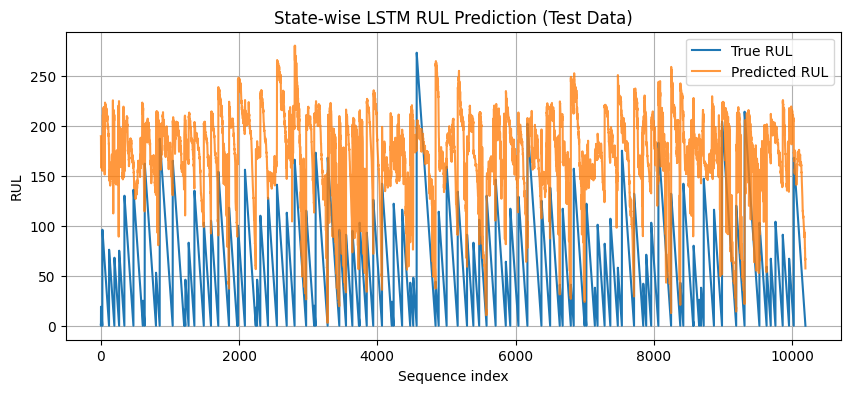

In [ ]:
# ============================================================
#  FINAL: STATE-WISE RUL PREDICTION ON TEST DATA
# ============================================================

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

# ------------------------------------------------------------
# 1) Load the converted .keras models
# ------------------------------------------------------------
models_dir = "models_state"

lstm_healthy = tf.keras.models.load_model(f"{models_dir}/lstm_state_Healthy.keras")
lstm_middle = tf.keras.models.load_model(f"{models_dir}/lstm_state_Middle.keras")
lstm_unhealthy = tf.keras.models.load_model(f"{models_dir}/lstm_state_Unhealthy.keras")

def get_model_for_state(state):
    if state == "Healthy": return lstm_healthy
    if state == "Middle":  return lstm_middle
    if state == "Unhealthy": return lstm_unhealthy
    raise ValueError(f"Unknown state {state}")

# ------------------------------------------------------------
# 2) Build test sequences per unit using your existing function
# ------------------------------------------------------------
test_sequences = []
test_states = []
test_true_rul = []

# health_state is already mapped in agg_test
unit_to_state = dict(zip(agg_test["unit"], agg_test["health_state"]))

# We must attach RUL for each row before sequence building
df_test_latent_rul = df_test_latent.copy()
# ------------------------------------------------------------
# Compute TRUE RUL for test data manually (safe method)
# ------------------------------------------------------------
df_test_rul = df_test.copy()
df_test_rul["RUL"] = df_test_rul.groupby("unit")["cycle"].transform(lambda x: x.max() - x)

# Merge RUL into latent test dataframe
df_test_latent_rul = df_test_latent.merge(
    df_test_rul[["unit", "cycle", "RUL"]],
    on=["unit", "cycle"],
    how="left"
)

# Check merge succeeded
if df_test_latent_rul["RUL"].isna().sum() > 0:
    missing = df_test_latent_rul[df_test_latent_rul["RUL"].isna()][["unit","cycle"]]
    print("Missing RUL rows:", missing.head())
    raise RuntimeError("RUL merge failed")

print("RUL successfully added to df_test_latent_rul.")

# ------------------------------------------------------------
# Build test sequences for each unit
# ------------------------------------------------------------

# IMPORTANT: build_sequences expects "rul" lowercase
df_test_latent_rul = df_test_latent_rul.rename(columns={"RUL": "rul"})

for unit, df_unit in df_test_latent_rul.groupby("unit"):
    state = unit_to_state[unit]

    # df_unit contains: z1..zk, unit, cycle, rul
    Xseq, yseq, meta = build_sequences(
        df_unit,
        latent_cols,
        seq_len=SEQ_LEN,
        stride=1
    )

    for x_s, y_s in zip(Xseq, yseq):
        test_sequences.append(x_s)
        test_states.append(state)
        test_true_rul.append(y_s)

test_sequences = np.array(test_sequences)
test_states = np.array(test_states)
test_true_rul = np.array(test_true_rul)


print("Total test sequences built:", len(test_sequences))
print("State distribution:", {s: list(test_states).count(s) for s in set(test_states)})

# ------------------------------------------------------------
# 3) Predict RUL using correct state-wise model
# ------------------------------------------------------------
def predict_rul(seq, state):
    seq = np.expand_dims(seq, axis=0)
    model = get_model_for_state(state)
    return float(model.predict(seq, verbose=0)[0][0])

preds = np.array([predict_rul(s, st) for s, st in zip(test_sequences, test_states)])

# ------------------------------------------------------------
# 4) Save results
# ------------------------------------------------------------
np.savez("rul_predictions_test.npz",
         preds=preds,
         true_rul=test_true_rul,
         states=test_states)

print("Saved predictions → rul_predictions_test.npz")

# ------------------------------------------------------------
# 5) Evaluate test performance (fixed for sklearn without `squared=`)
# ------------------------------------------------------------
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(test_true_rul, preds)
rmse = np.sqrt(mean_squared_error(test_true_rul, preds))   # <-- fixed

print(f"\nOverall Test MAE  = {mae:.3f}")
print(f"Overall Test RMSE = {rmse:.3f}")

# Per-state metrics (compute RMSE via sqrt of MSE)
for state in ["Healthy", "Middle", "Unhealthy"]:
    idx = np.where(test_states == state)[0]
    if len(idx) == 0:
        print(f"State {state}: no samples")
        continue
    mae_s = mean_absolute_error(test_true_rul[idx], preds[idx])
    rmse_s = np.sqrt(mean_squared_error(test_true_rul[idx], preds[idx]))
    print(f"\nState = {state}")
    print(f"  MAE  = {mae_s:.3f}")
    print(f"  RMSE = {rmse_s:.3f}")

# ------------------------------------------------------------
# 6) Plot predictions vs true RUL
# ------------------------------------------------------------
plt.figure(figsize=(10,4))
plt.plot(test_true_rul, label="True RUL")
plt.plot(preds, label="Predicted RUL", alpha=0.8)
plt.xlabel("Sequence index")
plt.ylabel("RUL")
plt.title("State-wise LSTM RUL Prediction (Test Data)")
plt.legend()
plt.grid(True)
plt.show()


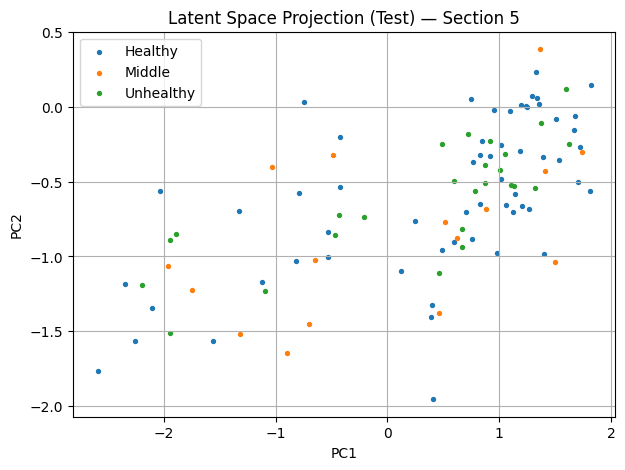

In [ ]:
# ============================================================
#  PLOT 5.1: Latent Space Trajectories (Colored by State)
# ============================================================

from sklearn.decomposition import PCA

# Take latent representation from test set
latent_vals = df_test_latent[latent_cols].values
states_test = agg_test["health_state"].values

# PCA to 2D for visualization
pca = PCA(n_components=2)
latent_2d = pca.fit_transform(latent_vals)

plt.figure(figsize=(7,5))
for state in ["Healthy", "Middle", "Unhealthy"]:
    idx = np.where(states_test == state)[0]
    plt.scatter(latent_2d[idx,0], latent_2d[idx,1], s=8, label=state)

plt.title("Latent Space Projection (Test) — Section 5")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.legend()
plt.show()


In [ ]:
import tensorflow as tf
import numpy as np
import os
from sklearn.metrics import mean_absolute_error, mean_squared_error

models_dir = "models_state"

# Load models (.keras format)
lstm_healthy   = tf.keras.models.load_model(os.path.join(models_dir, "lstm_state_Healthy.keras"))
lstm_middle    = tf.keras.models.load_model(os.path.join(models_dir, "lstm_state_Middle.keras"))
lstm_unhealthy = tf.keras.models.load_model(os.path.join(models_dir, "lstm_state_Unhealthy.keras"))

models = {
    "Healthy": lstm_healthy,
    "Middle":  lstm_middle,
    "Unhealthy": lstm_unhealthy
}

# Load scalers (saved as mean, scale)
scalers = {}
for st in ["Healthy", "Middle", "Unhealthy"]:
    data = np.load(f"{models_dir}/scaler_state_{st}.npz")
    scalers[st] = {
        "mean": data["mean"],
        "scale": data["scale"]
    }


In [ ]:
df_test_latent = compute_rul_per_row(df_test_latent)

X_test_all, y_test_all, meta_test = build_sequences(
    df_test_latent,
    latent_cols,
    seq_len=SEQ_LEN,
    stride=1
)

units_test = np.array([u for (u,_) in meta_test])


In [ ]:
unit_to_state = dict(zip(agg_test["unit"], agg_test["health_state"]))

test_states = np.array([unit_to_state[u] for u in units_test])


In [ ]:
seq_by_state = {"Healthy": [], "Middle": [], "Unhealthy": []}
true_by_state = {"Healthy": [], "Middle": [], "Unhealthy": []}

for x, y, st in zip(X_test_all, y_test_all, test_states):
    seq_by_state[st].append(x)
    true_by_state[st].append(y)

for st in seq_by_state:
    seq_by_state[st] = np.array(seq_by_state[st])
    true_by_state[st] = np.array(true_by_state[st])


In [ ]:
def scale_sequences(X, scaler):
    mean = scaler["mean"]
    scale = scaler["scale"]

    ns, sl, nf = X.shape
    X_flat = X.reshape(-1, nf)
    X_scaled = (X_flat - mean) / scale
    return X_scaled.reshape(ns, sl, nf)


In [ ]:
preds_by_state = {}

for st in ["Healthy", "Middle", "Unhealthy"]:
    if len(seq_by_state[st]) == 0:
        preds_by_state[st] = np.array([])
        print(f"{st}: No test samples")
        continue

    Xs_scaled = scale_sequences(seq_by_state[st], scalers[st])
    raw = models[st].predict(Xs_scaled, verbose=0)
    preds = raw[:, -1, 0]     # last timestep

    preds_by_state[st] = preds
all_preds_all = np.concatenate([preds_by_state[s] for s in ["Healthy","Middle","Unhealthy"] if len(preds_by_state[s])>0])


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

for st in ["Healthy", "Middle", "Unhealthy"]:
    y_true = true_by_state.get(st, np.array([]))
    y_pred = preds_by_state.get(st, np.array([]))

    if len(y_true) == 0 or len(y_pred) == 0:
        print(f"\n===== {st} =====\nSamples: 0 (skipping metrics)")
        continue

    # safety reshape to 1D
    y_true = np.ravel(y_true)
    y_pred = np.ravel(y_pred)

    if y_true.shape != y_pred.shape:
        print(f"\nWARNING: shape mismatch for {st}: y_true={y_true.shape}, y_pred={y_pred.shape}")
        # attempt best-effort alignment by trimming to min length
        m = min(len(y_true), len(y_pred))
        y_true = y_true[:m]
        y_pred = y_pred[:m]

    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)   # returns MSE
    rmse = np.sqrt(mse)                        # compute RMSE portably

    print(f"\n===== {st} =====")
    print(f"Samples: {len(y_true)}")
    print(f"MAE:  {mae:.3f}")
    print(f"RMSE: {rmse:.3f}")

# Combined overall metrics (defensive)
all_preds = []
all_true  = []
for st in ["Healthy","Middle","Unhealthy"]:
    p = preds_by_state.get(st, np.array([]))
    t = true_by_state.get(st, np.array([]))
    if len(p) > 0 and len(t) == len(p):
        all_preds.append(np.ravel(p))
        all_true.append(np.ravel(t))
    elif len(p) > 0 and len(t) > 0:
        m = min(len(p), len(t))
        all_preds.append(np.ravel(p[:m]))
        all_true.append(np.ravel(t[:m]))

if len(all_preds) > 0:
    all_preds = np.concatenate(all_preds)
    all_true  = np.concatenate(all_true)
    overall_mae = mean_absolute_error(all_true, all_preds)
    overall_rmse = np.sqrt(mean_squared_error(all_true, all_preds))
    print("\n===============================")
    print(" FINAL TEST PERFORMANCE")
    print("===============================")
    print(f"Overall MAE  = {overall_mae:.3f}")
    print(f"Overall RMSE = {overall_rmse:.3f}")
else:
    print("Not enough paired predictions+true labels to compute overall metrics.")



===== Healthy =====
Samples: 5842
MAE:  64.950
RMSE: 77.930

===== Middle =====
Samples: 1266
MAE:  88.937
RMSE: 93.421

===== Unhealthy =====
Samples: 3088
MAE:  63.886
RMSE: 76.351

 FINAL TEST PERFORMANCE
Overall MAE  = 67.606
Overall RMSE = 79.554


In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np

# # meta_test = list of (unit, cycle) for each test window
# # preds_by_state[state] = predictions (sorted in same order as X_test_all)
# # true_by_state[state]  = true RUL (same ordering)

# # First reconstruct engine-wise sequences
# engine_pred = {}
# engine_true = {}
# engine_cycle = {}

# for (unit, cycle), y_true, y_pred in zip(meta_test, y_test_all, all_preds_all):
#     if unit not in engine_pred:
#         engine_pred[unit] = []
#         engine_true[unit] = []
#         engine_cycle[unit] = []
#     engine_pred[unit].append(y_pred)
#     engine_true[unit].append(y_true)
#     engine_cycle[unit].append(cycle)

# # Now plot Figure-8 style graphs per engine
# for unit in sorted(engine_pred.keys()):
#     cycles = np.array(engine_cycle[unit])
#     idx = np.argsort(cycles)

#     plt.figure(figsize=(10,5))
#     plt.plot(cycles[idx], np.array(engine_true[unit])[idx], 
#              label="True RUL", linewidth=3)
#     plt.plot(cycles[idx], np.array(engine_pred[unit])[idx], 
#              label="Predicted RUL", linewidth=2)

#     plt.title(f"RUL Prediction — Engine {unit}", fontsize=14)
#     plt.xlabel("Cycle", fontsize=12)
#     plt.ylabel("Remaining Useful Life", fontsize=12)
#     plt.grid(True)
#     plt.legend()
#     plt.show()


In [ ]:
np.save("true_healthy.npy", true_by_state["Healthy"])
np.save("pred_healthy.npy", preds_by_state["Healthy"])

np.save("true_middle.npy", true_by_state["Middle"])
np.save("pred_middle.npy", preds_by_state["Middle"])

np.save("true_unhealthy.npy", true_by_state["Unhealthy"])
np.save("pred_unhealthy.npy", preds_by_state["Unhealthy"])


In [ ]:
print("Healthy:", true_by_state["Healthy"][:10], preds_by_state["Healthy"][:10])
print("Middle:", true_by_state["Middle"][:10], preds_by_state["Middle"][:10])
print("Unhealthy:", true_by_state["Unhealthy"][:10], preds_by_state["Unhealthy"][:10])


Healthy: [19 18 17 16 15 14 13 12 11 10] [133.5611  132.18063 132.39447 132.61917 133.54088 133.6322  134.75786
 133.82578 135.1473  134.74763]
Middle: [ 1  0 46 45 44 43 42 41 40 39] [147.13814 146.68987 140.05502 137.27013 135.20018 131.53285 133.00615
 128.76802 126.01178 126.30825]
Unhealthy: [130 129 128 127 126 125 124 123 122 121] [170.67499 160.18953 152.35785 153.39082 151.77943 151.33589 148.15651
 152.37022 153.91331 156.9094 ]


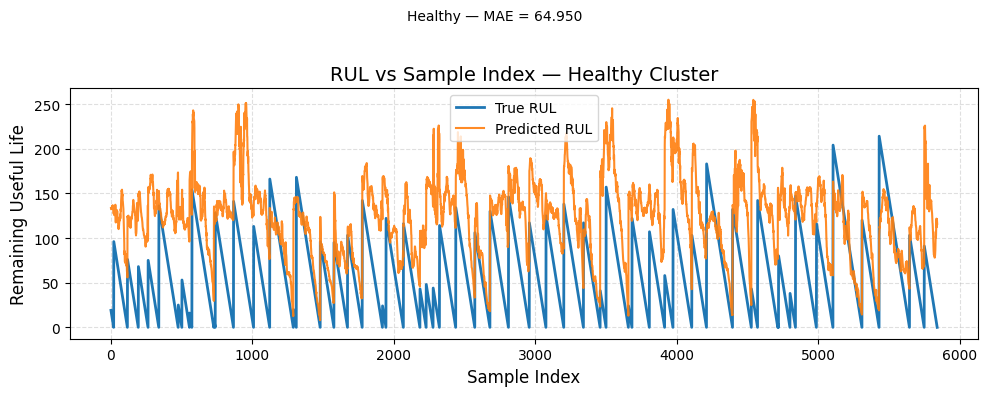

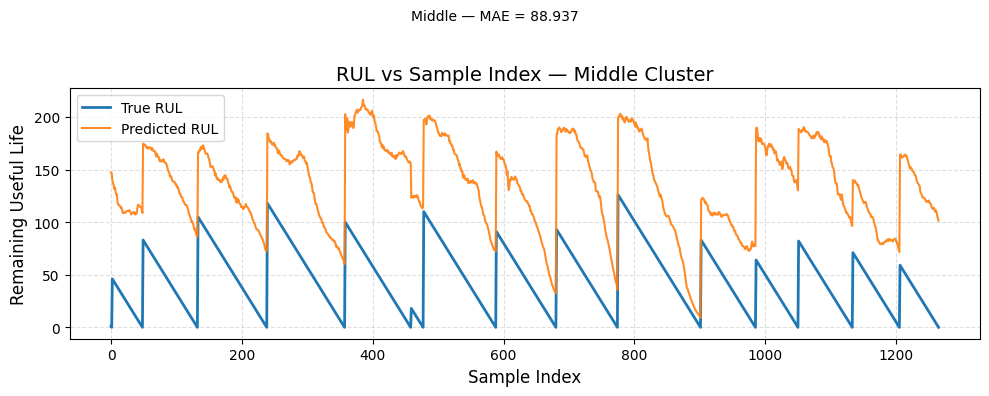

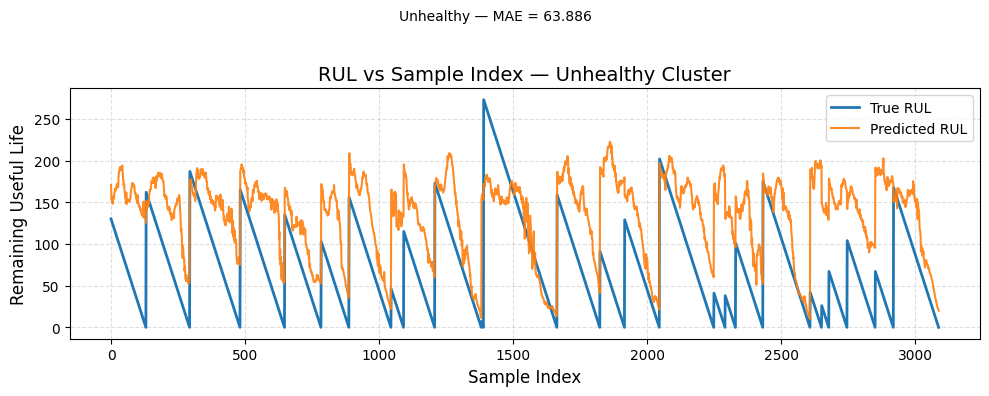

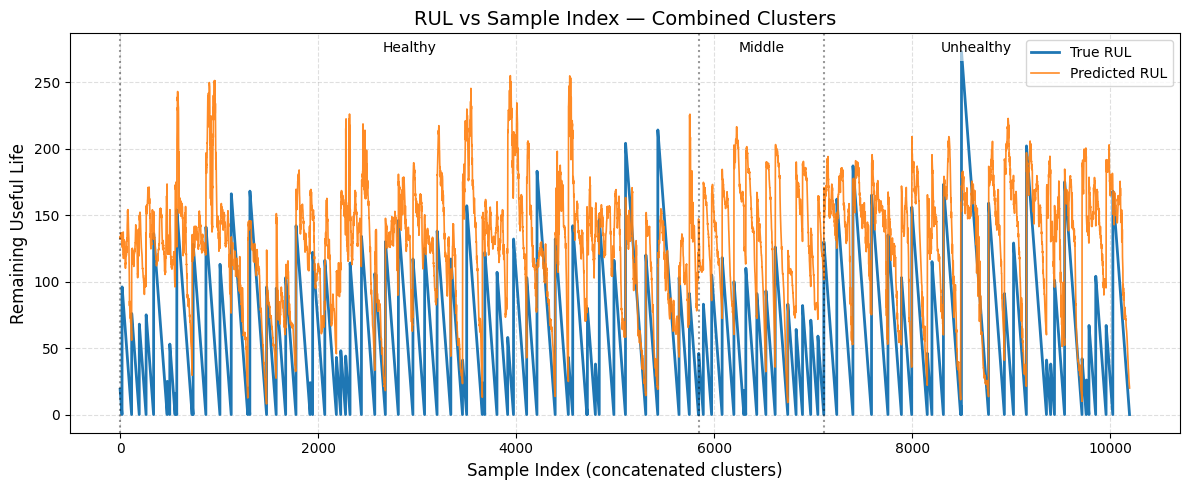

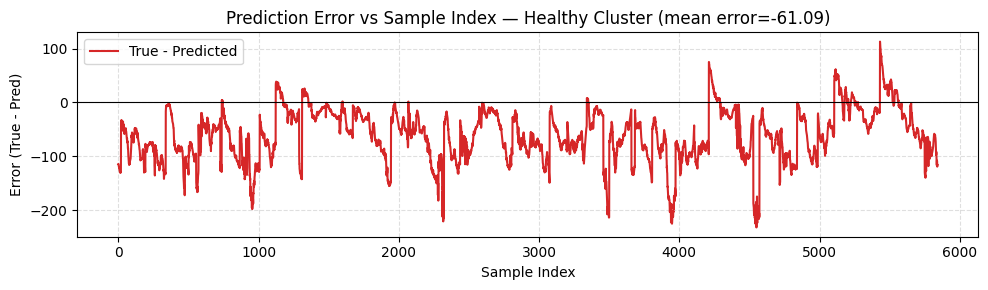

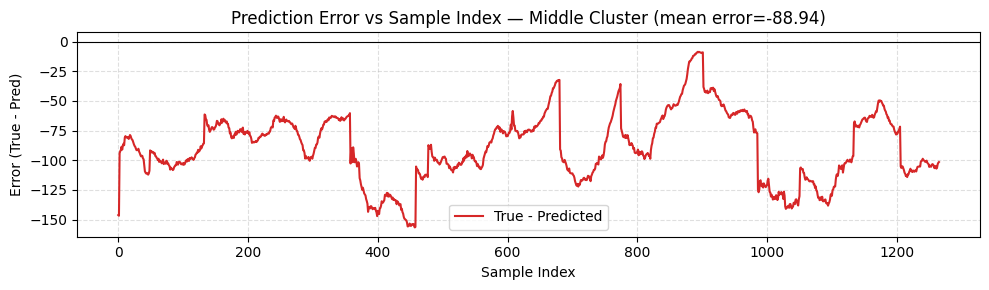

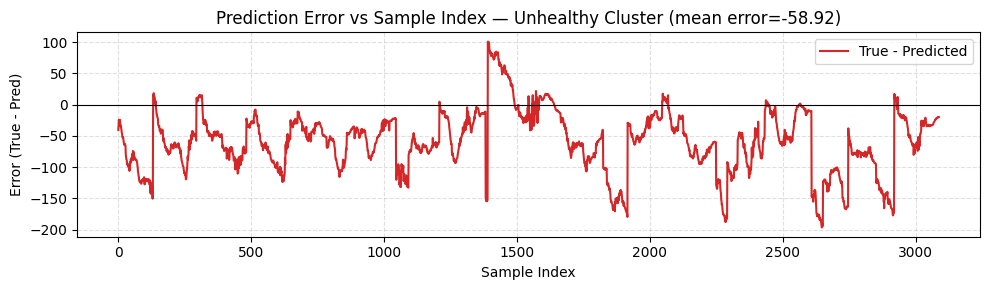

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error

clusters = ["Healthy", "Middle", "Unhealthy"]

# --- helper to ensure numpy arrays and 1D shapes ---
def to_1d(a):
    a = np.asarray(a)
    if a.ndim > 1:
        a = a.ravel()
    return a

# --- Plot per-cluster RUL vs sample index ---
for st in clusters:
    y_true = to_1d(true_by_state.get(st, np.array([])))
    y_pred = to_1d(preds_by_state.get(st, np.array([])))

    if y_true.size == 0 or y_pred.size == 0:
        print(f"{st}: missing data, skipping.")
        continue

    # if shapes mismatch, trim to min length (best-effort)
    if y_true.shape != y_pred.shape:
        m = min(len(y_true), len(y_pred))
        y_true = y_true[:m]
        y_pred = y_pred[:m]

    indices = np.arange(len(y_true))

    plt.figure(figsize=(10,4))
    plt.plot(indices, y_true, label="True RUL", linewidth=2)
    plt.plot(indices, y_pred, label="Predicted RUL", linewidth=1.5, alpha=0.9)
    plt.title(f"RUL vs Sample Index — {st} Cluster", fontsize=14)
    plt.xlabel("Sample Index", fontsize=12)
    plt.ylabel("Remaining Useful Life", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.legend()
    # optional: show MAE in the title
    mae = mean_absolute_error(y_true, y_pred)
    plt.suptitle(f"{st} — MAE = {mae:.3f}", y=0.98, fontsize=10)
    plt.tight_layout(rect=[0,0,1,0.95])
    plt.show()
    # save
    plt.savefig(f"rul_vs_index_{st}.png", dpi=200)
    plt.close()

# --- Combined plot: concatenate clusters in order Healthy, Middle, Unhealthy ---
all_true = []
all_pred = []
labels = []
for st in clusters:
    y_true = to_1d(true_by_state.get(st, np.array([])))
    y_pred = to_1d(preds_by_state.get(st, np.array([])))
    if y_true.size == 0 or y_pred.size == 0:
        continue
    # align lengths
    if y_true.shape != y_pred.shape:
        m = min(len(y_true), len(y_pred))
        y_true = y_true[:m]; y_pred = y_pred[:m]
    start_idx = len(all_true)
    all_true.extend(list(y_true))
    all_pred.extend(list(y_pred))
    labels.append((st, start_idx, start_idx + len(y_true) - 1))

all_true = np.array(all_true)
all_pred = np.array(all_pred)

if all_true.size > 0:
    indices = np.arange(len(all_true))
    plt.figure(figsize=(12,5))
    plt.plot(indices, all_true, label="True RUL", linewidth=2)
    plt.plot(indices, all_pred, label="Predicted RUL", linewidth=1.2, alpha=0.9)
    # mark cluster boundaries
    for (st, a, b) in labels:
        plt.axvline(x=a, color='k', linestyle=':', alpha=0.4)
        plt.text((a+b)/2, plt.ylim()[1]*0.95, st, horizontalalignment='center', fontsize=10, bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))

    plt.title("RUL vs Sample Index — Combined Clusters", fontsize=14)
    plt.xlabel("Sample Index (concatenated clusters)", fontsize=12)
    plt.ylabel("Remaining Useful Life", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.legend()
    plt.tight_layout()
    plt.show()
    plt.savefig("rul_vs_index_combined.png", dpi=200)
    plt.close()
else:
    print("No combined data to plot (no clusters had both true+pred).")

# --- Optional: error plots per cluster (true - pred) ---
for st in clusters:
    y_true = to_1d(true_by_state.get(st, np.array([])))
    y_pred = to_1d(preds_by_state.get(st, np.array([])))
    if y_true.size == 0 or y_pred.size == 0:
        continue
    if y_true.shape != y_pred.shape:
        m = min(len(y_true), len(y_pred))
        y_true = y_true[:m]; y_pred = y_pred[:m]

    err = y_true - y_pred
    indices = np.arange(len(err))

    plt.figure(figsize=(10,3))
    plt.plot(indices, err, label="True - Predicted", color='tab:red')
    plt.axhline(0, color='k', linewidth=0.8)
    plt.title(f"Prediction Error vs Sample Index — {st} Cluster (mean error={err.mean():.2f})")
    plt.xlabel("Sample Index")
    plt.ylabel("Error (True - Pred)")
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.legend()
    plt.tight_layout()
    plt.show()
    plt.savefig(f"rul_error_{st}.png", dpi=200)
    plt.close()
